### 1. Import dependencies

In [1]:
from __future__ import print_function, division
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [26]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

from torch.optim import lr_scheduler
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
torch.__version__

'1.0.1.post2'

### 2. Create PyTorch data generators

In [24]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])
}

image_datasets = {
    'train': 
    datasets.ImageFolder('data/pituitary_data/train', data_transforms['train']),
    'val': 
    datasets.ImageFolder('data/pituitary_data/val', data_transforms['val']),
    'test': 
    datasets.ImageFolder('data/pituitary_data/test', data_transforms['test'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=20,
                                shuffle=True, num_workers=4),
    'val':
    torch.utils.data.DataLoader(image_datasets['val'],
                                batch_size=20,
                                shuffle=False, num_workers=4),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=20,
                                shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(class_names)

['adenoma', 'nonneoplastic']


### 3. Create the network

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

### 4. Train the model

In [8]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            print('Labels: {}'.format(labels))
            print('Predictions: {}'.format(preds))

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    return model

In [9]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------


/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePl

Labels: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1])
Predictions: tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
train loss: 0.6393, acc: 0.5536


/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffI

Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1])
val loss: 0.5005, acc: 0.8250
Epoch 2/3
----------


/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImag

Labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1])
train loss: 0.4162, acc: 0.8071


/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffI

Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1])
val loss: 0.3581, acc: 0.8250
Epoch 3/3
----------


/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImag

Labels: tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Predictions: tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
train loss: 0.2577, acc: 0.9000


/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffI

Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1])
val loss: 0.2320, acc: 0.8750


### 5. Save and load the model

In [10]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [11]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

### 6. Make predictions on sample test images

In [12]:
validation_img_paths = ["data/pituitary_data/test/adenoma/CTMA_115_B_x6_y3_18_60X_HE_1.jpg",
                        "data/pituitary_data/test/nonneoplastic/CTMA_115_G_x1_y1_1_60X_HE_2.jpg",
                        "data/pituitary_data/test/adenoma/CTMA_115_B_x6_y5_30_60X_HE_3.jpg",
                       "data/pituitary_data/test/nonneoplastic/CTMA_115_G_x1_y6_31_60X_HE_3.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684354560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/chinasa/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2684485632 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


In [13]:
validation_batch = torch.stack([data_transforms['val'](img).to(device)
                                for img in img_list])

In [14]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

print(pred_probs)
print(pred_logits_tensor)

[[0.88891435 0.11108568]
 [0.05471991 0.9452801 ]
 [0.9023946  0.09760537]
 [0.02984483 0.9701552 ]]
tensor([[ 1.5427, -0.5370],
        [-0.7426,  2.1067],
        [ 1.5569, -0.6673],
        [-1.0400,  2.4414]], grad_fn=<AddmmBackward>)


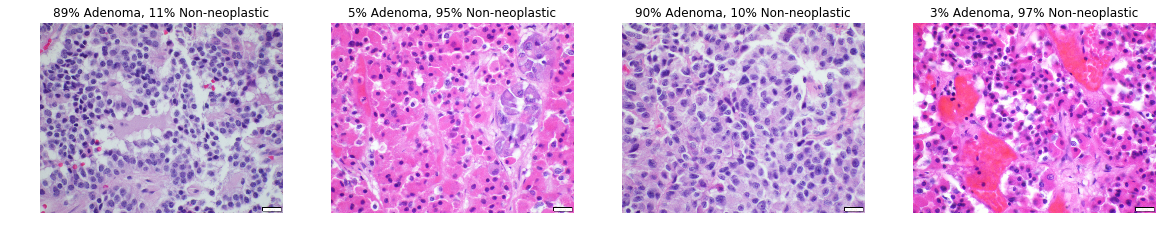

In [15]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Adenoma, {:.0f}% Non-neoplastic".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)

### 7. Get metrics on sample test images

In [16]:
# Figure out how to get class labels automatically and run through the testing dataloader instead of calling images manually
# Find 

from sklearn.metrics import roc_auc_score


Computed ROC AUC Score: 1.0
False positive rate: [0. 0. 0. 1.]
True positive rate: [0.  0.5 1.  1. ]


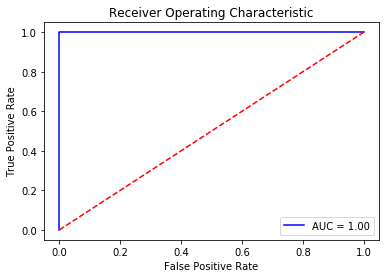

<Figure size 432x288 with 0 Axes>

In [25]:
# Compute ROC AUC Score
y_true = np.array([0, 1, 0, 1])
y_scores = np.array([.84, 0.96, 0.83, 0.97])
roc_auc_score(y_true, y_scores)

true_labels = np.array(y_true) # Numpy array of binary class for each tested image
prob_scores = np.array(y_scores) # Numpy array of confidence percentages of each tested image
auc_roc = roc_auc_score(true_labels, prob_scores)
print('Computed ROC AUC Score: {}'.format(auc_roc))

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
print('False positive rate: {}'.format(fpr))
print('True positive rate: {}'.format(tpr))

# Plot computed metrics
plt.figure()
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()
plt.savefig('ROC.jpg')